<a href="https://colab.research.google.com/github/mlites/mlites2019/blob/master/intro_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Linear Regression and Gradient Descent

Hello! In this exercise we'll peek behind the scenes at the deceptively simple linear regression algorithm by implementing a gradient descent version`

Along the way we'll learn to do some data manipulation in python using Pandas and NumPy, and learn how to separate our data into Training and Test sets for validation.

If you haven't already, make sure you run intro_kaggle.ipynb to download the necessary datasets


More background
* [Introduction to Machine Learning Algorithms: Linear Regression](https://towardsdatascience.com/introduction-to-machine-learning-algorithms-linear-regression-14c4e325882a)

* [Quick start to Pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html)


## Outline

1. import necessary packages
2. Load Iditarod data
3. Do some date and time conversion
4. Generate some new features
5. Plot some data
6. Fit regression with sklearn
7. Fit regression with gradient descent

## Getting Started

In [0]:
import pandas as pd #import Pandas under the shortcut 'pd'
import numpy as np #import NumPy; NumPy is the fundamental package for scientific computing with Python
import matplotlib.pyplot as plt #MatPlotLib is a plotting library

## Exploring the Iditarod Dataset

In [4]:
# first lets load the Iditarod data into a pandas dataframe in a variable called 'iditarod'

iditarod = pd.read_csv("iditarod.csv")
iditarod.tail()

FileNotFoundError: ignored

There is a bunch of data here about each musher, like when they arrived at each checkpoint, how long it took, what their speed was, and how many dogs they checked in or out.

Let's explore the data a bit to see what it looks like. Say we're interested in how the number of dogs on the team affects the speed, we can plot that using the MatPlotLib library.

Let's look at the speed versus the number of dogs dropped by each team.

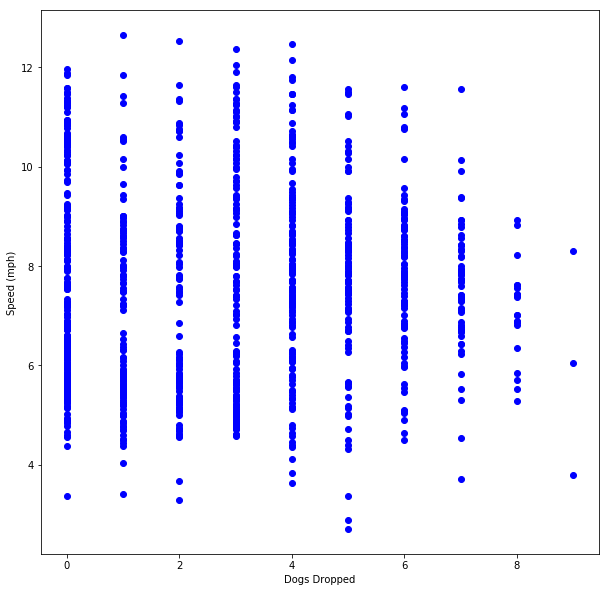

In [120]:
iditarod["Dogs_dropped"] = 16 - iditarod["Arrival Dogs"] #everyone starts with 16 dogs
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.scatter(iditarod["Dogs_dropped"],iditarod["Speed"],color='blue') # the scatter command make a scatter plot
plt.xlabel("Dogs Dropped")
plt.ylabel("Speed (mph)")
plt.show()

**Questions:**
* What do you think, is there a trend?
* Do mushers go faster when they have more dogs?
* What other factors might affect their speed?


Let's do some feature conversions and dig into the data a bit more.

In [0]:
#let's drop values that have NA or NaN's
iditarod = iditarod.dropna()

#then convert the times into machine-readable timestamps

# import the datetime module
from datetime import datetime

# get the Date and Time into a new temporary dataframe
# pd.loc[] accesses rows or columns in a dataframe by character labels
dt = iditarod.loc[:, ['Arrival Date', 'Arrival Time']] # : means 'all rows'

# 'apply' applies a function (in this case anonymous, or 'lambda') to each row (axis=1) of the new dataframe
# this function concatenates the Date and Time and converts them into a special 'datetime' object
# which then gets saved back into the original dataframe

iditarod['Arrival_datetime'] = dt.apply(lambda x: datetime.strptime(x[0]+'/'+x[1], '%m/%d/%Y/%H:%M:%S'), axis=1)

# another way to make datetime objects in pandas
# iditarod["Arrival Time"] = pd.DatetimeIndex(iditarod["Arrival Time"],dtype='datetime64[ns]')
# iditarod["Departure Time"] = pd.DatetimeIndex(iditarod["Departure Time"],dtype='datetime64[ns]')


Now we can plot the number of Dogs Dropped as a function of the Datetime

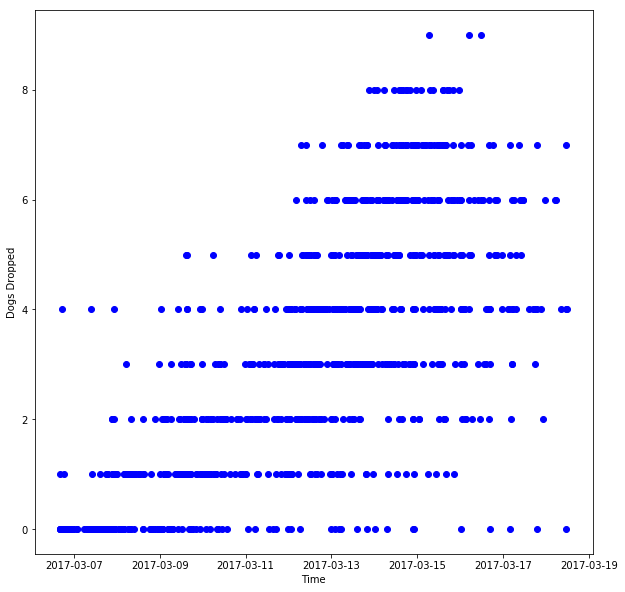

In [123]:
# plot_data is a matplotlib command to use when you're plotting a date or time
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.plot_date(iditarod["Arrival_datetime"],iditarod["Dogs_dropped"],color='blue') #make a scatter plot
plt.xlabel("Time")
plt.ylabel("Dogs Dropped")
plt.show()


Is there a trend here?

It kind of looks like it, but how can we tell for sure?

Let's look at one more example.

In [124]:
# let's find the cumulative time and distance traveleled to each checkpoint

# first we'll find the unique checkpoints like this:
iditarod["Checkpoint"].unique()

# then from the Iditarod website we can find the cumulative distances
# to each unique checkpoint
# https://iditarod.com/race-map/

# and input them into a new dictionary ('dict') like so:
cumulative_dist = {
'Fairbanks'	: 0,
'Nenana'	: 71,
'Manley'	: 161,
'Tanana'	: 227,
'Ruby'	: 346,
'Galena'	: 396,
'Huslia'	: 478,
'Koyukuk'	: 564,
'Nulato'	: 586,
'Kaltag'	: 633,
'Unalakleet'	: 718,
'Shaktoolik'	: 758,
'Koyuk'	: 808,
'Elim'	: 856,
'White Mountain'	: 902,
'Safety'	: 957,
'Nome'	: 979
}

# now we can the insert those into the iditarod dataframe using the 'replace()' function like so:
iditarod["Distance_traveled"] = iditarod["Checkpoint"].replace(cumulative_dist)

# finally lets convert the timestamps into hours elapsed since the the start of the race
# we subtract the Arrival time from the race start time and use the .astype() function to report the time difference in hours
# I know what you're saying -- this isn't perfectly accurate because they actually do a 2-minute staggered start, but I'll leave that as an exercise for the reader

racestart = pd.Timestamp('2017-03-06 11:00:00.00000')
iditarod["Elapsed_time"] = (iditarod["Arrival_datetime"] - racestart).astype('timedelta64[h]')

# now let's take a look at our new features
iditarod.head()

,Number,Name,Status,Country,Checkpoint,Latitude,Longitude,Distance,Time,Speed,...,Elapsed Time,Departure Date,Departure Time,Departure Dogs,Arrival_datetime,Cumulative_distance,Cumulative_hours,Distance_traveled,Elapsed_time,Dogs_dropped
72,6,Linwood Fiedler,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.05,11.88,...,3.93,03/06/2017,20:07:00,16.0,2017-03-06 16:11:00,71,5.0,71,5.0,0.0
73,5,Cody Strathe,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.22,11.50,...,0.12,03/06/2017,16:26:00,16.0,2017-03-06 16:19:00,71,5.0,71,5.0,0.0
74,4,Misha Wiljes,Rookie,Czech Republic,Nenana,64.5952,-149.0897,60.0,5.25,11.43,...,5.93,03/06/2017,22:15:00,15.0,2017-03-06 16:19:00,71,5.0,71,5.0,1.0
75,9,Michelle Phillips,Veteran,Canada,Nenana,64.5952,-149.0897,60.0,5.18,11.58,...,3.48,03/06/2017,19:54:00,16.0,2017-03-06 16:25:00,71,5.0,71,5.0,0.0
76,15,Martin Buser,Veteran,United States,Nenana,64.5952,-149.0897,60.0,5.02,11.96,...,0.23,03/06/2017,16:41:00,16.0,2017-03-06 16:27:00,71,5.0,71,5.0,0.0


Ok, your turn!

Fill in the missing details to make a scatter plot of the Elapsed Time as a function of the Distance Traveled

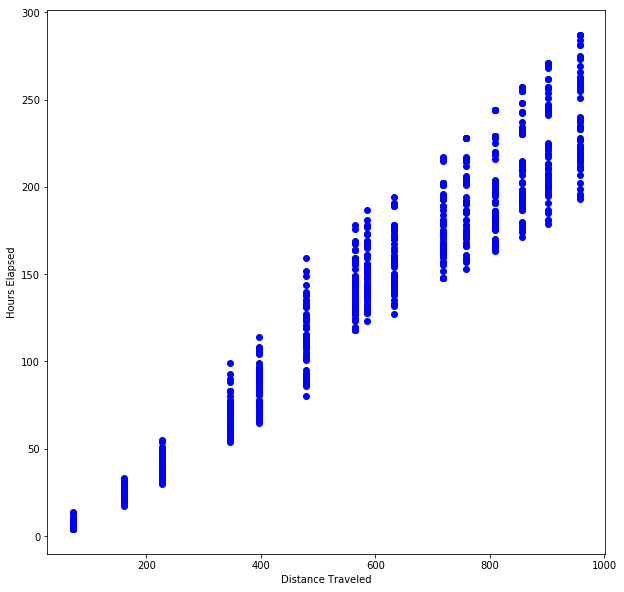

In [57]:
plt.figure(figsize=(10,10)) #set the figure size in inches
plt.scatter(iditarod[""],iditarod[""],color='blue') #make a scatter plot
plt.xlabel("Distance Traveled")
plt.ylabel("Elapsed Time")
plt.show()

## Introducing Training and Testing Sets

In Machine Learning, the way we validate how well the machines are learning is by using two subsets of any given dataset: a Train set, and a Test set. Let's say we split the data 80/20 between these subsets, this means we'll use80% of the data to Train our model, and 20% to Test whether our predictions are any good.


**Some questions for you:**

* Why don't we train on the whole data set?
* Wouldn't we get a better model that way?
* Think about the answers and we'll come back to it later.

First, let's work with the Elapsed Time and Distance Traveled data, and split it into Train and Test sets.

We'll use scikit-learn, a simple but powerful machine learning toolkit for python.

docs: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [0]:
import sklearn #import the scikit-learn package
from sklearn.model_selection import train_test_split #import the train_test_split function

x = iditarod["Distance_traveled"]
y = iditarod["Elapsed_time"]

# here we tell sklearn to split our data and reserve 20% for the test set
# train_test_split automatically shuffles the data before returning the splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) 

# need to convert data to numpy array and reshape data for input into linear model
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)

## sklearn LinearRegression

Now that we've split the data into training and testing sets, let's do some linear regression. We'll use the LinearRegression module from sklearn first.

In [2]:
from sklearn.linear_model import LinearRegression # import the LinearRegression module from sklearn
from sklearn.metrics import r2_score # import the r2_score module from sklearn

clf = LinearRegression() # initiate an object of Class LinearRegression
clf.fit(x_train,y_train) # call the fit() function to fit the training data x_train and y_train

NameError: ignored

Now that we have a model trained on the training set, we can use it to predict new values.

For example, if the Iditarod was 1100 miles long instead of 1000, how many hours would it take the average musher to finish?


In [1]:
y_pred = clf.predict([np.array(1100)]) # we need double brackets because predict() expects an array of arrays
print(y_pred[0]) # [0] to access the first value in the y_pred array

NameError: ignored

Let's print out the formula for our best fit line using the coefficients found within the 'clf' object

In [138]:
# the formula for the best fit line is
slope = clf.coef_[0]
intercept = clf.intercept_
print("y = " + str(slope) + "x" + " + " + str(intercept)) #str() converts a numeric to a string

# get control of those significant figures by printing with nicer formatting
print("y = %.2fx + %.2f" % (slope, intercept)) # %.2f says to format a _f_loating-point number to 2 decimal places

y = 0.2682487215156617x + -15.802236413973844
y = 0.27x + -15.80


Now let's plot the best fit line over the training and testing data

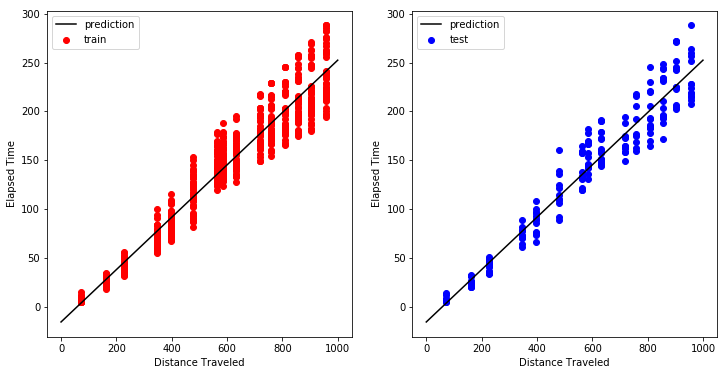

In [139]:
x_fit = np.linspace(0,1000, 50) # linspace(start, stop, num) generates a linearly-spaced numeric array
y_fit = slope*x_fit + intercept

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1) #subplot(nrows, ncols, index) allows for multiple plots on one page
plt.scatter(x_train,y_train,color='red',label='train')
plt.plot(x_fit,y_fit,color='black',label = 'prediction')
plt.legend()
plt.xlabel("Distance Traveled")
plt.ylabel("Elapsed Time")

plt.subplot(1, 2, 2)
plt.scatter(x_test,y_test,color='blue',label='test')
plt.plot(x_fit,y_fit,color='black',label = 'prediction')
plt.legend()
plt.xlabel("Distance Traveled")
plt.ylabel("Elapsed Time")

plt.show()

Finally, let's use the Test set to validate how well we did on our predictions.

We'll use the R<sup>2</sup> test to do so along with the sklearn predict() function


In [155]:
y_pred = clf.predict(x_test)
print('R2 Score:',r2_score(y_test,y_pred))

# if we wanted to do the prediction manually we could do it like this
y_pred = slope * x_test + intercept
print('R2 Score:',r2_score(y_test,y_pred))


R2 Score: 0.9426935278718954
R2 Score: 0.9426935278718954


Not too bad!

**Question:** What features might we add to make our predictions better next time?

## Roll-your-own Linear Regression

"Training a machine learning algorithm or a neural network is really just the process of minimizing the cost function"

Let's see how that works under the hood


More info:
  * [Linear Regression in Python](https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606)
  
  * [Linear Regression Using Gradient Descent in 10 Lines of Code](https://towardsdatascience.com/linear-regression-using-gradient-descent-in-10-lines-of-code-642f995339c0)
  
  *  [Linear Regression using Gradient Descent](https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931)




(0.05011814603055602, 7.128498070605024e-05, 14928.122847702725)


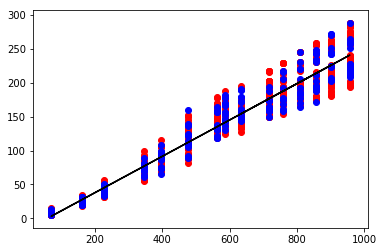

In [276]:
## Linear Regression by iterative least squares

# let's define a function that implements the gradient descent
# def linear_regression(X, y, slope_current=0, intercept_current=0, epochs=1000, learning_rate=0.00001):
#      N = float(len(y))
#      for i in range(epochs):
#           y_current = (slope_current * X) + intercept_current
#           error = y - y_current
#           cost = np.sum(error**2)/N
#           slope_gradient = -(2/N) * np.sum(X * (error))
#           intercept_gradient = -(2/N) * np.sum(error)
#           slope_current = slope_current - (learning_rate * slope_gradient)
#           intercept_current = intercept_current - (learning_rate * intercept_gradient)
#           if(i%10 == 0):
#             print(cost)      
#      return slope_current, intercept_current, cost
        
# linear_regression(x_train, y_train)
# #           cost = sum([data**2 for data in (y-y_current)]) / N

X = iditarod["Distance_traveled"].values
Y = iditarod["Elapsed_time"].values

def linear_regression(X, y, m_current=0, b_current=0, epochs=1000, learning_rate=0.0001):
    N = float(len(y))
    for i in range(epochs):
          y_current = (m_current * X) + b_current
          cost = np.sum([data**2 for data in (y - y_current)]) / N
          m_gradient = -(2/N) * np.sum(X * (y - y_current))
          b_gradient = -(2/N) * np.sum(y - y_current)
          m_current = m_current - (learning_rate * m_gradient)
          b_current = b_current - (learning_rate * b_gradient)
    return m_current, b_current, cost
  
lg = linear_regression(X, Y, learning_rate=1e-9, epochs=300)
print(lg)

y_pred = slope * x_test + intercept
plt.scatter(x_train,y_train,color="red")
plt.scatter(x_test,y_test,color="blue")
plt.plot(x_test,y_pred,color='black',label = 'prediction')


0.24573983443355474 -0.01762353001666048


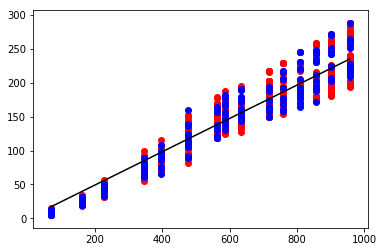

In [275]:
X = iditarod["Distance_traveled"].values
Y = iditarod["Elapsed_time"].values

m = 0
c = 0

L = 0.000001  # The learning Rate
epochs = 3000  # The number of iterations to perform gradient descent

n = float(len(X)) # Number of elements in X

# Performing Gradient Descent 
for i in range(epochs): 
    Y_pred = m*X + c  # The current predicted value of Y
    D_m = (-2/n) * sum(X * (Y - Y_pred))  # Derivative wrt m
#     print(D_m)
    D_c = (-2/n) * sum(Y - Y_pred)  # Derivative wrt c
#     print(D_c)
    m = m - L * D_m  # Update m
#     print(m)
    c = c - L * D_c  # Update c
#     print(c)
    
print (m, c)


y_pred = m * X + c
plt.scatter(x_train,y_train,color="red")
plt.scatter(x_test,y_test,color="blue")
plt.plot(X,y_pred,color='black',label = 'prediction')

In [242]:
m = 0
c = 0

L = 0.0001  # The learning Rate
epochs = 1000  # The number of iterations to perform gradient descent

n = float(len(X)) # Number of elements in X

i=1
Y_pred = m*X + c  # The current predicted value of Y
D_m = (-2/n) * sum(X * (Y - Y_pred))  # Derivative wrt m
D_c = (-2/n) * sum(Y - Y_pred)  # Derivative wrt c
m = m - L * D_m  # Update m
c = c - L * D_c  # Update c

print(c)


0.026635493519441673


ValueError: ignored

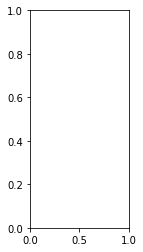

In [212]:
# plt.subplot(1, 3, 1) #subplot(nrows, ncols, index) allows for multiple plots on one page
# plt.scatter(range(len(lg[2])),lg[0])
# plt.subplot(1, 3, 2) #subplot(nrows, ncols, index) allows for multiple plots on one page
# plt.scatter(range(len(lg[2])),lg[1])
# plt.subplot(1, 3, 3) #subplot(nrows, ncols, index) allows for multiple plots on one page
# plt.scatter(range(len(lg[2])),lg[2])


In [0]:
# For simple linear regression it's possible to calculate the coefficients exactly
# but that's not always possible

# https://mubaris.com/posts/linear-regression/
# https://www.cs.toronto.edu/~frossard/post/linear_regression/

# Mean X and Y
mean_x = np.mean(X)
mean_y = np.mean(Y)

# Total number of values
m = len(X)

# Using the formula to calculate b1 and b2
numer = 0
denom = 0
for i in range(m):
    numer += (X[i] - mean_x) * (Y[i] - mean_y)
    denom += (X[i] - mean_x) ** 2
b1 = numer / denom
b0 = mean_y - (b1 * mean_x)

# Print coefficients
print(b1, b0)